# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Вторая лабораторная работа </center>
# <center> Анализ сигналов </center>

In [1]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib

# Запретим numpy выполнять деление на 0
np.seterr(divide='raise', invalid='raise') 
%matplotlib inline

In [2]:
# Определим две функции для отрисовки сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)

def draw_sig(frames, name=None, figsize=(14, 3)):
    # Отрисовка сигнала в виде "леденцов на палочке"
    plt.figure(figsize=figsize)
    plt.stem(frames)
    if name is not None:
        plt.legend([name])
    plt.xlabel("n")
    plt.ylabel("Energy")
    plt.show()
    

In [3]:
# Создадим несколько простых сигналов. Они нам понадобятся для дальшейшего тестирования
signals = {}

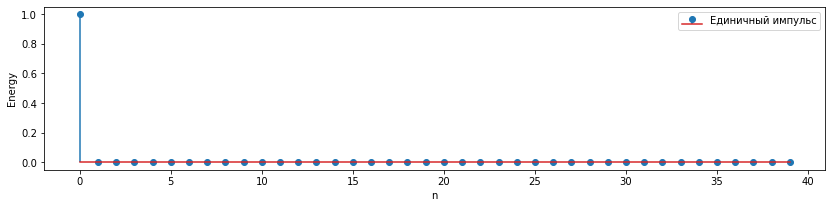

In [4]:
name = "Единичный импульс"
signals[name] = np.array([1] + [0]*39, dtype=float)
draw_sig(signals[name], name)

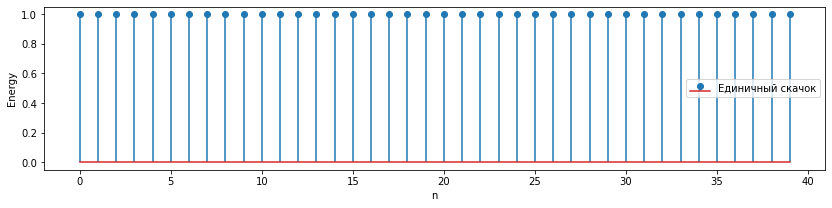

In [5]:
name = "Единичный скачок"
signals[name] = np.array([1]*40 ,dtype=float) 
draw_sig(signals[name], name)

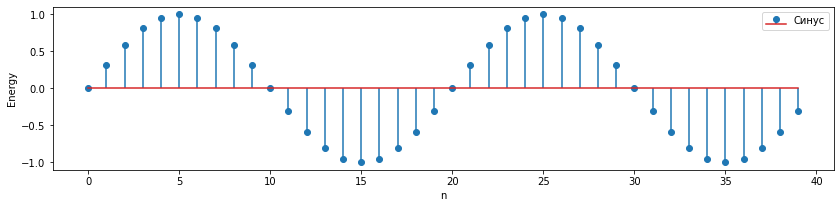

In [6]:
name = "Синус"
signals[name] = np.sin(np.pi * np.arange(40)/10)
draw_sig(signals[name], name)

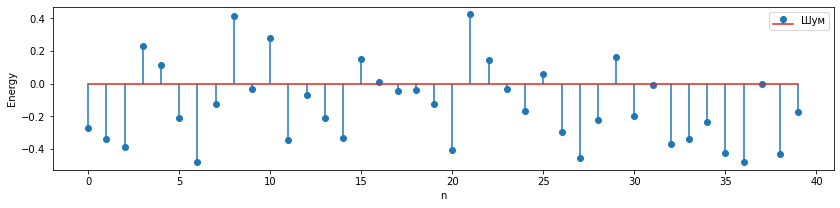

In [7]:
name = "Шум"
signals[name] = np.random.random(40)-0.5
draw_sig(signals[name], name)

-------------------------------
# Преобразование Фурье
Прежде, чем перейти к анализу сигналов, надо разобраться, что такое преобразование Фурье. 
> Преобразование Фурье (символ ℱ) — операция, сопоставляющая одной функции вещественной переменной другую функцию вещественной переменной. Эта новая функция описывает коэффициенты («амплитуды») при разложении исходной функции на элементарные составляющие — гармонические колебания с разными частотами (подобно тому, как музыкальный аккорд может быть выражен в виде суммы музыкальных звуков, которые его составляют). [Wiki](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5)



Формула прямого дискретного преобразования Фурье (ДПФ, Discrete Fourier Transform, DFT)):
$$ X_k = \sum_{n=0}^{N-1} x_n * e^{2i\pi k n/N} $$


# Задание 1 (2 балла)
Реализовать дискретное преобразование Фурье. Сравнить с реализацией scipy.fft.fft

In [8]:
def DFT(x):
    # YOUR CODE HERE
    N = len(x)
    n = np.arange(N)
    k = np.arange(N).reshape((N, 1))    
    res = np.dot(np.exp(-2j * np.pi * k * n / N), x)
    return res
    #
#     raise NotImplementedError()

In [9]:
def test_DTF(x, transform=DFT):
    # Сравнение с библиотекой scipy
    scipy_result = scipy.fft.fft(x)
    curr_result = transform(x)
    if scipy_result.shape != curr_result.shape:
        print("TEST_FAILED")
        print(f"Your spectrogram shape is {curr_result.shape}. "
              f"Scipy spectrogram shape is {scipy_result.shape}")
        return -1
    if not np.allclose(curr_result, scipy_result):
        print("TEST FAILED")
        print(f"scipy spectrogram: {scipy_result}")
        print(f"Your DTF spectrogram: {curr_result}")
        print(f"Average diff is {np.mean(np.abs(scipy_result - curr_result))}")
        return -2
    print("TEST PASSED")
    return 0

for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


Класическое ДПФ имеет существенный недостаток - сложность алгоритма $O(N^2)$. На данный момент существуют чуть более сложные реализации преобразования Фурье, которые избавляются от квадратичной сложности. Например, алгоритм быстрого преобразования Фурье (Fast Fourier Transform, FFT) имеет сложность $O(N log(N))$, что делает его значительно более быстрым на длинных последовательностях. 

# Задание 1.1* (1 балл)
Реализовать быстрое преобразование Фурье. Сравнить с scipy.fft.fft

In [10]:
def FFT(x):
    # YOUR CODE HERE
    N = len(x)
    if N <= 6:
        return DFT(x)
    else:
        x_even = FFT(x[::2])   
        x_odd = FFT(x[1::2])        
        exp_term = np.exp(-2j * np.pi * np.arange(N) / N)
        w1 = x_even + exp_term[: N // 2] * x_odd
        w2 = x_even + exp_term[N // 2 :] * x_odd
        return np.hstack((w1, w2))
#     raise NotImplementedError()

In [11]:
for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig, transform=FFT) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


# Амплитудный и фазовый спектры
Поскольку преобразование Фурье определено в комплекстной области, анализировать результат напрямую проблематично. Для анализа сигналов принято разбивать результат преобразования Фурье на два спектра: амплитудный и фазовый. Амплитудный показывает, как меняется модуль сигнала, а фазовый - как меняется угол, образуемый на комплексной плоскости. 
# Задание 2 (1 балл)

Реализовать функции построения амплитудного и фазового спектра

In [12]:
#функция построения амплитудного спектра
def get_amplitude_from_spec(spec):
    # YOUR CODE HERE
    return np.abs(spec)
    #
#     raise NotImplementedError()

#функция построения фазового спектра
def get_phi_from_spec(spec):
    # YOUR CODE HERE
    return np.angle(spec)
    #
#     raise NotImplementedError()

In [13]:
def check_mean_var(sig, mean=None, var=None):
    if mean is not None and np.mean(sig) != mean:
        print(f"Bad mean. Expected {mean}, got {np.mean(sig)}")
        return False
    if var is not None and np.var(sig) != var:
        print(f"Bad var. Expected {var}, got {np.var(sig)}")
        return False
    return True

_spec = scipy.fft.fft(np.array([1]+[0]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 0.0), \
    "Wrong Amplitude"
assert check_mean_var(get_phi_from_spec(_spec), 0.0, 0.0), \
    "Wrong Phase"

    
_spec = scipy.fft.fft(np.array([1]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 9.0), \
    "Wrong  Amplitude"
assert get_amplitude_from_spec(_spec)[0] == 10, \
    "Wrong Amplitude"
assert get_phi_from_spec(_spec)[0] == 0, \
    "Wrong phase"

_spec = scipy.fft.fft(scipy.fft.ifft(np.array([0] + [10+5j]+[0]*6 + [10-5j])))
assert get_amplitude_from_spec(_spec).round(1)[1] == 11.2 , \
    "Wrong Amplitude. Make sure it is a complex number module."
assert get_phi_from_spec(_spec).round(1)[1] == 0.5 , \
    "Wrong Amplitude. Make sure it is an angle."

   
print("All OK!")

All OK!


In [14]:
# Определим еще одну функцию для отрисовки
# Теперь будем рисовать сигнал в частотной области
def draw_spec(spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3)):
    if len(spec)<100:
        # Рисуем точки как "леденцы на палочках"
        draw_func = plt.stem
    else:
        # При большом N "леденцы" выглядят плохо, 
        # Поэтому будем рисовать огибающую функцию
        draw_func = plt.plot
    
    if draw_A:
        plt.figure(figsize=figsize)
        plt.title("Amplitude spectrum")
        spec_A = get_amplitude_from_spec(spec)
        draw_func(spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
        
    if draw_p:
        plt.figure(figsize=figsize)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.ylabel("Radian")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
    return 

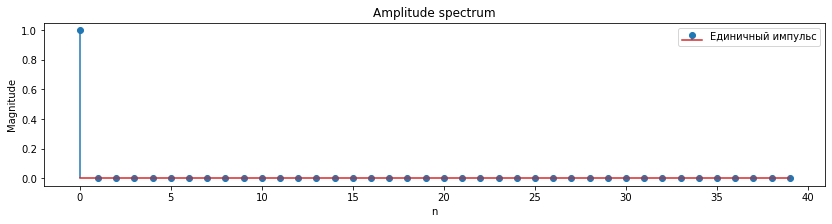

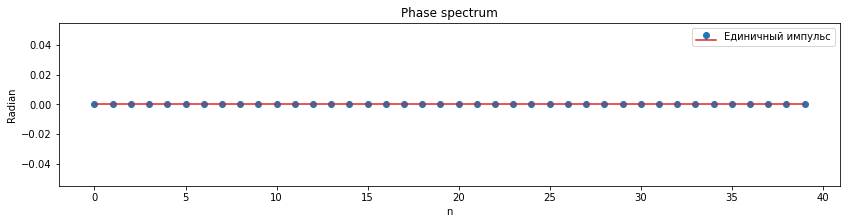

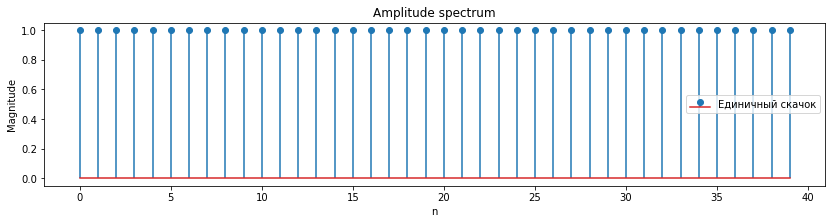

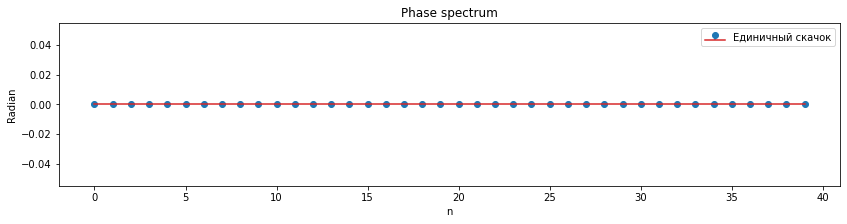

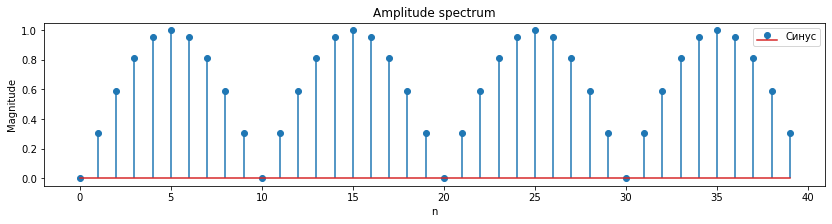

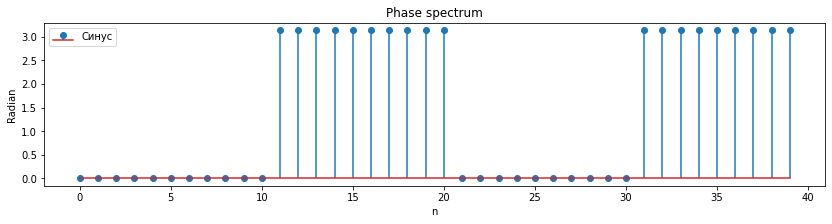

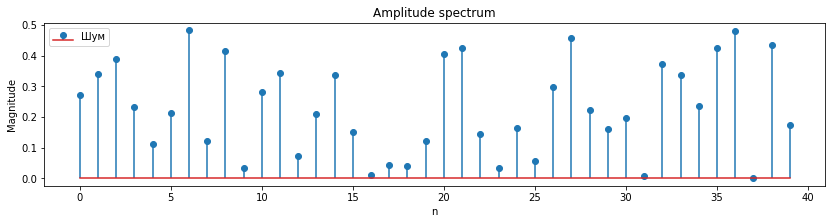

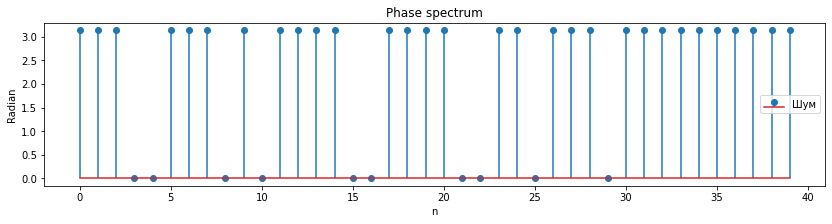

In [15]:
for name, sig in signals.items():
    draw_spec(sig, name)

# Задание 2.1 (0.5 балла)
Постройте спектры для всех сигналов из коллекции signals и ответьте на вопросы:
1. Почему амплитуда всех гармоник единичного импульса равна единице? 
1. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый? 
1. Как перевести номер отсчета в частоту?  
1. Что в фазовом спектре является полезной информацией, а что - шумом? Почему?

1. -
2. -
3. fk = k * f_д / N, где k - номер отсчета, N - количество отсчетов, f_д - частота дискретизации
4. -

# Оконное преобразование Фурье
Преобразование Фурье делает переход из временной области в частотную, позволяя анализировать составляющие сигнал гармоники. Однако это не всегда удобно. В реальных сигналах зачастую составляющие их гармоники изменяются со временем. Например, каждая буква в слове имеет свой набор основных гармоник, и простое преобразование Фурье не сильно поможет нам определить, что было сказано. Для того, чтобы анализировать такие сигналы, обычно используется [Оконное преобразование Фурье](https://ru.wikipedia.org/wiki/Оконное_преобразование_Фурье). Такое преобразование позволяет анализировать гармоники сигнала в коротких промежутках времени и сохранить временную ось при построении спектрограммы.
# Задание 3 (2 балла)
Реализовать оконное преобразование Фурье, пользуясь только библиотеками numpy и scipy. Сравнить с librosa.stft


In [16]:
def STFT(x, n_fft=2048, hop_length=512, window='hann'):
    #  Short-time Fourier transform
    # x - signal
    # n_fft - fft window size 
    # hop_length - step size between ffts
    # window - window type. See scipy.signal.get_window
    # return spectrogram 
    
    # YOUR CODE HERE
    # STFT is computed in the following procedure:
      # 1. Devide the input signal into N section. Each time n points are taken, where n is equal to the Window length specified.
      # 2. The chosen Window Type is used to multiply the extracted data, point-by-point.
      # 3. Zeros will be padded on both sides of the window, if the Window length is less than the size of the FFT Length.
      # 4. FFT is computed on the FFT section.
      # 5. Move the window according to the user-specified Overlap size, and repeat steps 1 through 4 until the end of the input signal is reached.

    verbose = False

    fft_window = scipy.signal.get_window(window, n_fft)
    if verbose:
        print("x = ", x, "; len(x) = ", len(x))
        print("window = ", fft_window, "; len(window) = ", len(fft_window))

    padded_signal = np.pad(x, int(n_fft // 2), 'reflect')
    
    if verbose:
          print("padded signal = ", padded_signal, "; len(padded_signal) = ", len(padded_signal))
 
    num_of_cols = (len(padded_signal) - len(fft_window)) // (len(fft_window) - (len(fft_window) - hop_length)) + 1
    num_of_rows = int(n_fft // 2 + 1)

    res = np.zeros(( num_of_cols, num_of_rows), dtype=np.complex64)

    if verbose:
          print("num_of_cols = ", num_of_cols, "num_of_rows = ", num_of_rows, "res_shape = ", res.shape)



    for i in range(num_of_cols):                      
        current_step = hop_length * i                  
        res[i, :] = np.fft.fft(padded_signal[current_step : current_step + n_fft] * fft_window)[:num_of_rows]

    return res.T
    

In [17]:
def test_stft(x, n_fft=2048, hop_length=512, window='hann'):
    librosa_result = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, window='hann', center=True)
    result = STFT(x, n_fft=n_fft, hop_length=hop_length, window='hann')
    if librosa_result.shape != result.shape:
        print(f"Your shape {result.shape} != librosa stft shape {librosa_result.shape} ")
        return -1 
    if not np.allclose(librosa_result, result):
        print(f"Wrong results. Diff {np.abs(librosa_result-result)}")
        return -2
    return 0
        
for name, sig in signals.items():
    print(f"Checking '{name}'")
    for n_fft in (8, 4):
        for hop_length in (n_fft//4, n_fft//2):
            assert test_stft(sig, n_fft=n_fft, hop_length=hop_length)==0, \
                f"Test failed. Params n_fft {n_fft}. Hop_length {hop_length}"
    print("ok")
print("All ok!")

Checking 'Единичный импульс'
ok
Checking 'Единичный скачок'
ok
Checking 'Синус'
ok
Checking 'Шум'
ok
All ok!


In [18]:
# Определим функцию для отрисовки
def draw_stft(X, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    # X - комплекстная спектрограмма 
    # Для получения энергии достаточно взять модуль
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.show()

# Анализ сигналов
Теперь можно приступить к анализу звуковых сигналов.
Во время анализа сигналов нам понадобятся все определенные выше инструменты. 


----------------------------------
## Анализ паровозного гудка
Начнем с простого сигнала, состоящего из нескольких основных гармоник и шума.

Len is 82175 ( ). Sample rate is 22050


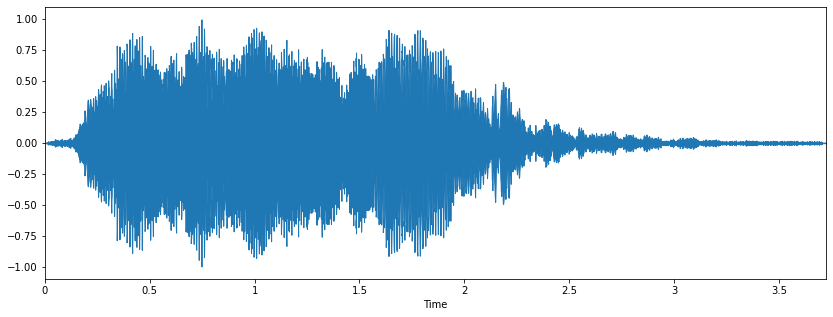

In [87]:
# Загрузим аудио файл с паровозным гудком
train_whistle, tw_sr = librosa.core.load("resources/train_whistle.wav")
print(f"Len is {len(train_whistle)} ( ). Sample rate is {tw_sr}")
player = ipd.Audio(train_whistle, rate=tw_sr)
ipd.display(player)
draw_waveform(train_whistle, sr=tw_sr)

Гудок паровоза в частотной области


<IPython.core.display.Javascript object>


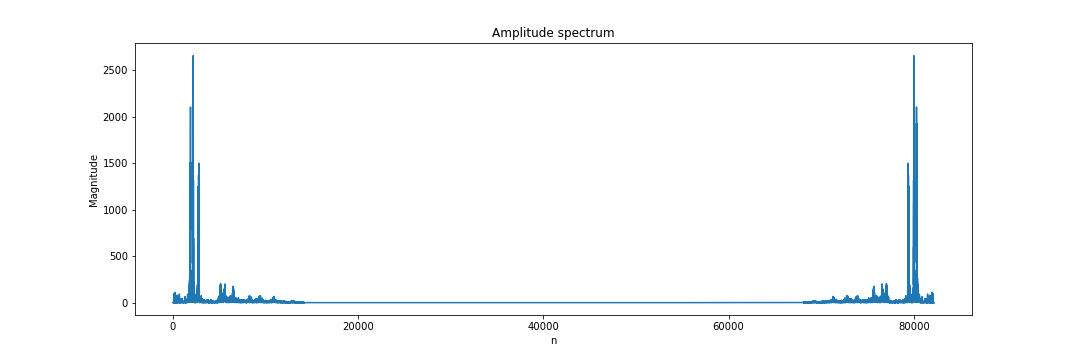

In [94]:
train_whistle_spec = scipy.fft.fft(train_whistle)
print("Гудок паровоза в частотной области")
draw_spec(train_whistle_spec, draw_p=False, figsize=(15,5))

# Задание 4 (2 балла)
Определите 3 основные гармоники паровозного гудка.

Ответ округлите до двух знаков после запятой.


<IPython.core.display.Javascript object>


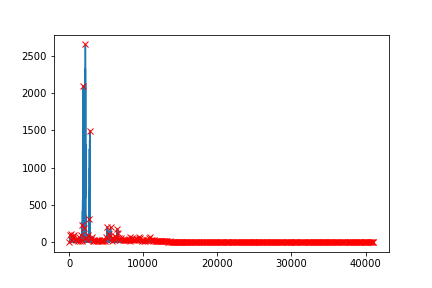

N =  82175
fd =  22050
task_answer =  [747.29844843 505.80164284 585.76391847]


In [162]:
# YOUR CODE HERE
# task_answer = [ freq1, freq2, freq3 ]

N = len(train_whistle_spec)

fd = tw_sr

half_arr = get_amplitude_from_spec(train_whistle_spec[: N // 2])
peaks, _ = scipy.signal.find_peaks(half_arr, distance = 100, )
plt.figure()
plt.plot(half_arr)
plt.plot(peaks, half_arr[peaks], "xr")

idx = half_arr[peaks].argsort()[-3:]

task_answer_idx = []
for i in idx:
    n = np.where(half_arr == half_arr[peaks][i])[0][0]
    task_answer_idx.append(n)

task_answer_idx = np.array(task_answer_idx)
task_answer = task_answer_idx * fd / N


print("N = ", N)
print("fd = ", fd)
print("task_answer = ", task_answer)


In [163]:
assert type(task_answer) == list or type(task_answer) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(task_answer)}"
assert len(task_answer) == 3, \
        f"Wrong len {len(task_answer)}."
assert (round(sum(task_answer)) == 1677 and round(np.var(task_answer)) == 1407) or \
        (abs(sum(task_answer)  - 1836) <= 3 and abs(np.var(task_answer) - 10153) <= 181), \
        f"Wrong freqs"
print("Correct!")       

Correct!


Теперь попробуйте сгенерировать сигнал, состоящий только из этих гармоник. Воспроизведите сигнал.

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


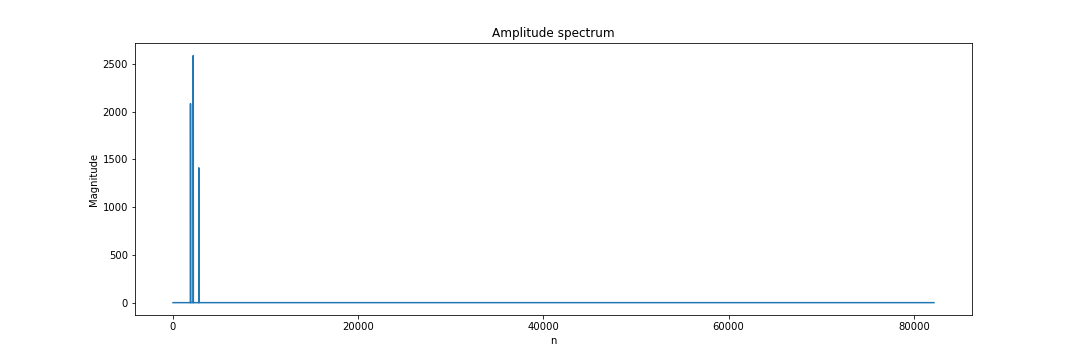

In [173]:
#YOUR CODE HERE
edited_spec = np.copy(train_whistle_spec)
edited_spec = np.zeros(len(train_whistle_spec))
edited_spec[task_answer_idx] = train_whistle_spec[task_answer_idx]
draw_spec(edited_spec, draw_p=False, figsize=(15,5))

Len is 82175 ( ). Sample rate is 22050


<IPython.core.display.Javascript object>


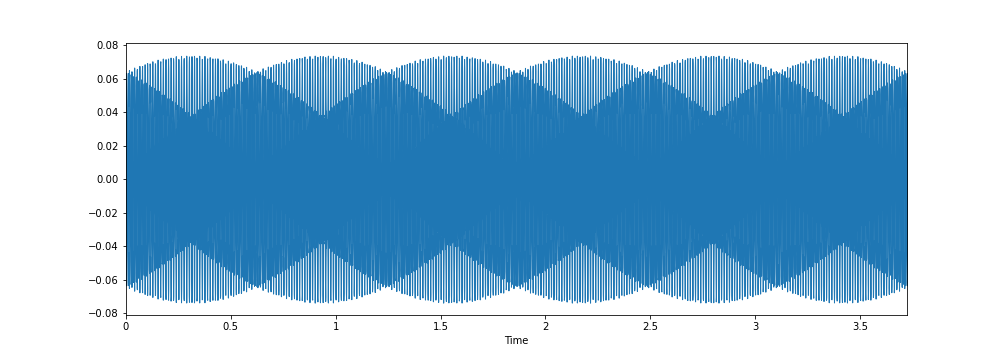

D:\Anaconda\lib\site-packages\librosa\util\utils.py:200: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)


In [179]:
reconstructed_audio = scipy.fft.ifft(edited_spec)
# librosa.istft(edited_spec)
print(f"Len is {len(reconstructed_audio)} ( ). Sample rate is {tw_sr}")
player = ipd.Audio(reconstructed_audio, rate=tw_sr)
ipd.display(player)
draw_waveform(reconstructed_audio.real, sr=tw_sr)

# Анализ двухтонального многочастотного сигнала
Теперь расмотрим более сложный сигнал - [DTMF](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling). Такие сигналы используются для автоматизации набора телефонного номера. 

# Задание 5 (2 балла)
В данном аудио закодирован трехзначный номер. Используя таблицу с [wiki]:(https://ru.wikipedia.org/wiki/DTMF) определите, что за номер закодирован.


Len is 243102. Sample rate is 22050


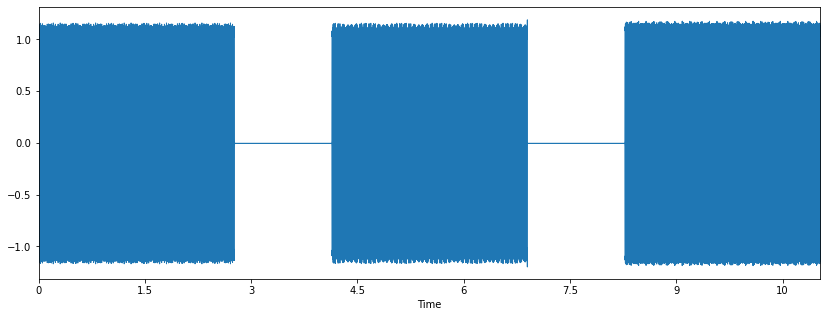

In [259]:
#dtmf.wav
dtmf, dtmf_sr = librosa.core.load("resources/dtmf.wav")
print(f"Len is {len(dtmf)}. Sample rate is {dtmf_sr}")
player = ipd.Audio(dtmf, rate=dtmf_sr)
ipd.display(player)
draw_waveform(dtmf, sr=dtmf_sr)

Телефония


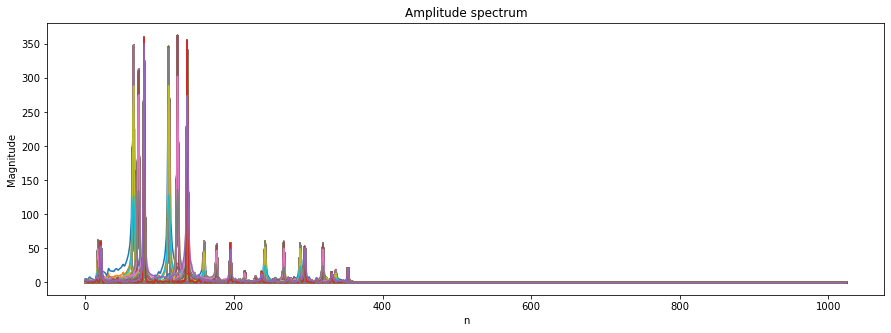

In [260]:
dtmf_librosa_spec = librosa.stft(dtmf, 2048, 512, window='hann', center=True)
print("Телефония")
draw_spec(dtmf_librosa_spec, draw_p=False, figsize=(15,5))

D:\Anaconda\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
D:\Anaconda\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
D:\Anaconda\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


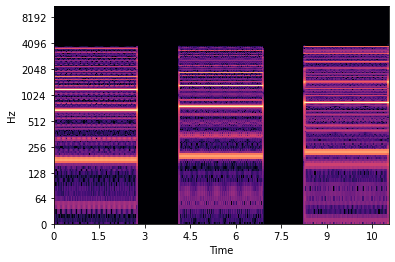

In [261]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(dtmf_librosa_spec), ref=np.max), sr=dtmf_sr, hop_length = 512,
                          y_axis='log', x_axis='time', )

Гудок паровоза в частотной области


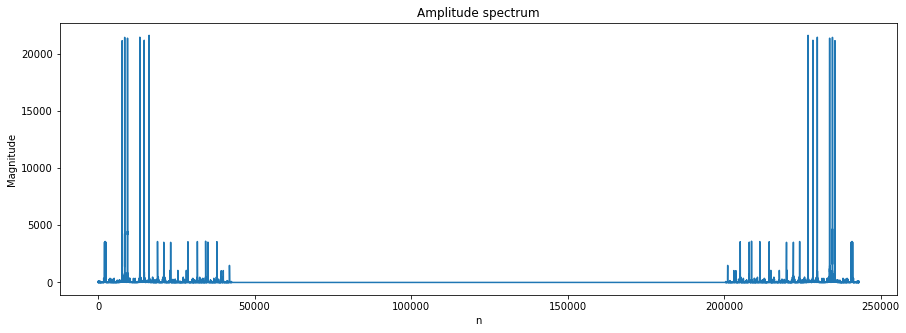

In [274]:
dtmf_spec = scipy.fft.fft(dtmf)
print("Гудок паровоза в частотной области")
draw_spec(dtmf_spec, draw_p=False, figsize=(15,5))

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(5000.0, 20000.0)

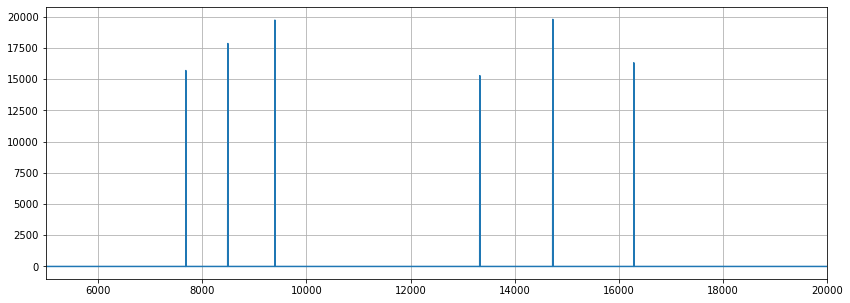

In [284]:
dtmf_spec[dtmf_spec < 10000] = 0
plt.figure(figsize=(14, 5))
plt.plot(dtmf_spec)
plt.grid()
plt.xlim([5000, 20000])

D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(5000.0, 20000.0)

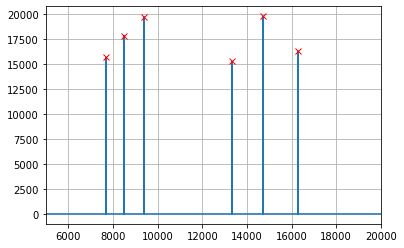

In [290]:
peaks, _ = scipy.signal.find_peaks(dtmf_spec[:18000], distance = 100,)
plt.figure()
plt.plot(dtmf_spec)
plt.plot(peaks, dtmf_spec[peaks], "xr")
plt.grid()
plt.xlim([5000, 20000])

In [296]:
print(peaks)
print("Положения пиков", peaks * (dtmf_sr / len(dtmf_spec)))

[ 7683  8490  9393 13328 14730 16285]
Положения пиков [ 696.86859837  770.06565145  851.97016067 1208.88515932 1336.05029987
 1477.09294864]


In [295]:
# Первая цифра (697, 1209)
# Вторая цифра (770, 1336)
# Третья цифра (852, 1477)
phone_number = np.array([1, 5, 9])

In [293]:
assert type(phone_number) == list or type(phone_number) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(phone_number)}"
assert len(phone_number) == 3, \
        f"Wrong len {len(phone_number)}."
assert round(np.mean(phone_number)) == 5 and round(np.var(phone_number)) == 11 , \
        f"Wrong number"
assert hashlib.md5(''.join(map(str, phone_number)).encode()).hexdigest() == "140f6969d5213fd0ece03148e62e461e", \
        f"Wrong hash. How did you pass mean/var test?"
print("Correct!")   

Correct!
